In [1]:
%matplotlib inline

### Data used in 2.3 and 2.4

The generated data follow this procedure:

1)  Generate 10 means for each class such that:

    $M_{blue}\sim N\left(\left[\begin{matrix}
    1\\
    0\\
    \end{matrix}\right],
    \left[\begin{matrix}
    1&0\\
    0&1\\
    \end{matrix}\right]\right)$ 
    and 
    $M_{orange}\sim N\left(\left[\begin{matrix}
    0\\
    1\\
    \end{matrix}\right],
    \left[\begin{matrix}
    1&0\\
    0&1\\
    \end{matrix}\right]\right)$

    The random variables $M_{\text{blue}}$ and $M_{\text{orange}}$ have
    their two components independent.
    
    Therefore we have two sets:
    $m_{blue}=\left\{m_{blue}^{\left(1\right)},
    \ldots,m_{blue}^{\left(10\right)}\right\}$
    and
    $m_{orange}=\left\{m_{orange}^{\left(1\right)},
    \ldots,m_{orange}^{\left(10\right)}\right\}$

2)  Generate $N$ observations for each class such that for each observation in blue 
    (resp. orange) class:
    - We pick randomly (i.e. with a probability of 0.1) one mean
      in $m_{blue}$ (resp. $m_{orange}$)
    - We generate the observation $x_{blue}$ (resp. $x_{orange}$), such that:
      $X_{blue}\sim N\left(m_{blue},
      \left(\begin{matrix}
      0.2&0\\
      0&0.2\\
      \end{matrix}\right)\right)$
      and resp. 
      $X_{orange}\sim N\left(m_{orange},
      \left(\begin{matrix}
      0.2&0\\
      0&0.2\\
      \end{matrix}\right)\right)$

Rule to convert the fifted value $\hat{Y}$ to a fifted class variable $\hat{G}$ is,
$$
\hat{G}=\begin{cases}
Orange, \hat{Y}>0.5\\
Blue, \hat{Y}\le 0.5
\end{cases}
$$

In [2]:
import numpy as np
import numpy.random as rand

In [3]:
# Function that generates the data
def generate_data(sample_size: int) -> tuple:

    # Parameters for mean gaussian distribution
    mean_mu_blue = [1,0]
    mean_mu_orange = [0,1]
    mean_cov = np.eye(2) 
    
    # Generate 10 means for the blue class and the orange class
    nb_real = 10
    blue_means = rand.multivariate_normal(mean_mu_blue,mean_cov, nb_real)
    orange_means = rand.multivariate_normal(mean_mu_orange,mean_cov, nb_real)
    
    # Parameter for data gaussian distribution
    data_cov = np.eye(2)/5
    
    # Function that generates an observation for the blue class
    x_blue = lambda : rand.multivariate_normal(blue_means[rand.randint(0, 9)],
                                               data_cov)
    # Function that generates an observation for the orange class
    x_orange = lambda : rand.multivariate_normal(orange_means[rand.randint(0, 9)],
                                                 data_cov)
    # Generate the sample X
    X = np.array([
        np.vstack((x_blue(), x_orange()))
        for _ in range(int(sample_size/2))
    ])
    
    X = X.reshape(sample_size, 2)
  
    # Generate the sample y
    y = np.empty((sample_size,))
    y[::2] = 0
    y[1::2] = 1
    
    return (X, y)

In [4]:
# Generate data
sample_size = 200
data_x, data_y = generate_data(sample_size)
x_blue = data_x[data_y == 0, :]
x_orange = data_x[data_y == 1, :]

In [5]:
import matplotlib.pyplot as plt

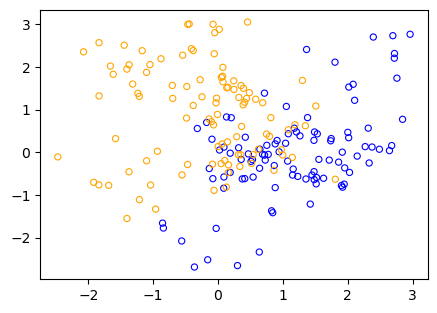

In [6]:
def plot_data(x_blue: np.array, x_orange:np.array):
    
    fig, ax = plt.subplots(1, figsize=(5, 3.5))
    
    ax.scatter(x_blue[:, 0], x_blue[:, 1], marker='o', s=20,
               linewidth=0.8, facecolors='none', edgecolors='blue')
    ax.scatter(x_orange[:, 0], x_orange[:, 1], marker='o', s=20,
               linewidth=0.8, facecolors='none', edgecolors='orange')
    
    return ax
    
ax = plot_data(x_blue, x_orange)

## 2.3  Two Simple Approaches to Prediction: Least Squares and Nearest Neighbors

### 2.3.1 Linear Models and Least Squares

#### Model

The linear model is the following: 
$$y=\beta_0+\beta_1x_1+\beta_2x_2+\ldots+\beta_px_p=\beta_0+\sum_{i=1}^{p}{\beta_ix_i}$$
For $N$ inputs such that the output vector $\boldsymbol{Y}$ is $(N,1)$ we have:
$$\boldsymbol{Y}_{\left(N,1\right)}=\beta_0\mathbb{1}_{\left(N,1\right)}+\sum_{i=1}^{N}x_i^T\beta_{\left(p,1\right)}$$
With $x_i^T=\left(\begin{matrix}x_1^{\left(i\right)}&x_2^{\left(i\right)}&\ldots&x_p^{\left(i\right)}\\\end{matrix}\right)$ and $\beta_{\left(p,1\right)}^T=\left(\begin{matrix}\beta_1&\beta_2&\ldots&\beta_p\\\end{matrix}\right)$

If $\boldsymbol{X}_{\left(N,p+1\right)}=\left(\begin{matrix}1&x_1^{\left(1\right)}&x_2^{\left(1\right)}&\ldots&x_p^{\left(1\right)}\\1&x_1^{\left(2\right)}&x_2^{\left(2\right)}&\ldots&x_p^{\left(2\right)}\\\vdots&\vdots&\vdots&\ldots&\vdots\\1&x_1^{\left(N\right)}&x_2^{\left(N\right)}&\ldots&x_p^{\left(N\right)}\\\end{matrix}\right)$ and 
$\beta_{\left(p+1,1\right)}=\left(\begin{matrix}\beta_0\\\beta_1\\\vdots\\\beta_p\\\end{matrix}\right)$ then:

$$\boldsymbol{Y}_{\left(N,1\right)}=\boldsymbol{X}_{\left(N,p+1\right)}\beta_{\left(p+1,1\right)}$$

#### Fit

$$RSS\left(\beta\right)=\sum_{i=1}^{N}\left(y_i-x_i^T\beta\right)^2 \tag {2.3}$$

$u^Tu=\left(\begin{matrix}u_1&u_2&\ldots&u_N\\\end{matrix}\right)\left(\begin{matrix}u_1\\u_2\\\vdots\\u_N\\\end{matrix}\right)=\sum_{i=1}^{N}u_i^2$ and $\left(\begin{matrix}u_1\\u_2\\\vdots\\u_N\\\end{matrix}\right)=\left(\begin{matrix}y_1-x_1^T\beta\\y_2-x_2^T\beta\\\vdots\\y_N-x_N^T\beta\\\end{matrix}\right)=\left(\begin{matrix}y_1\\y_2\\\vdots\\y_N\\\end{matrix}\right)-\left(\begin{matrix}x_1^T\beta\\x_2^T\beta\\\vdots\\x_N^T\beta\\\end{matrix}\right)=\boldsymbol{y}-\boldsymbol{X}\beta$ then,

$$RSS\left(\beta\right)=\left(\boldsymbol{y}-\boldsymbol{X}\beta\right)^T\left(\boldsymbol{y}-\boldsymbol{X}\beta\right) \tag {2.4}$$

To determine the vector $\hat{\beta}$ which minimizes $RSS$ we would use the fact that $RSS$ is convex. The proof of the convexity and its use to determine $\hat{\beta}$ will be fully described in section x.x. If $(\boldsymbol{X}^T\boldsymbol{X})$ is nonsigular then the unique solution is,

$$\hat{\beta}=\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y} \tag {2.6}$$

In [7]:
from numpy.linalg import inv

In [8]:
def linear_model_fit(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    
    # Add column of one as the first column of X
    X = np.column_stack((np.ones(len(y)), X))
    
    # Formula (2.6)
    coef = inv(X.T @ X) @ X.T @ y.T
    
    return coef

reg_linear_coef = linear_model_fit(data_x, data_y)

#### Example

In [9]:
# Function that generates a 2-dimensional grid
def generate_grid(nb_point_ax: int, x1_min: float, x1_max: float,
               x2_min: float, x2_max: float) -> np.ndarray:
    
    return np.array([[i,j]
                 for i in np.linspace(x1_min, x1_max, nb_point_ax)
                 for j in np.linspace(x2_min, x2_max, nb_point_ax)]
               )

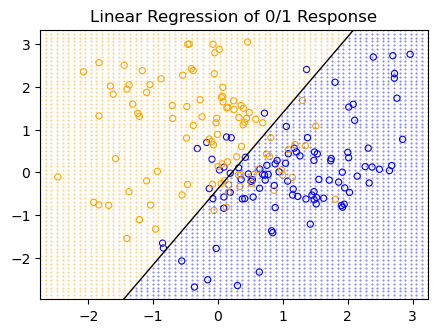

In [10]:
# data plot
ax = plot_data(x_blue, x_orange)

# Get the minimum and the maximum of both axes in the AxesSubplot
# of plot_data function
x1_min, x1_max = ax.get_xlim()
x2_min, x2_max = ax.get_ylim()

# Set the grid
grid = generate_grid(70, x1_min, x1_max, x2_min, x2_max)

# Predictions with the rule previously defined
grid_pred = np.column_stack((np.ones(len(grid)), grid)) @ reg_linear_coef
grid_blue = grid[grid_pred <= 0.5]
grid_orange = grid[grid_pred > 0.5]

# Plot the predicted grid 
ax.scatter(grid_blue[:, 0], grid_blue[:, 1], marker='.',
           color='blue', alpha=0.5, s=1)
ax.scatter(grid_orange[:, 0], grid_orange[:, 1], marker='.',
           color='orange', alpha=0.5, s=1)

# Plot the boundary
line = lambda x1: ((0.5 - (reg_linear_coef[0]+x1*reg_linear_coef[1])) / 
                   reg_linear_coef[2])
ax.plot([x1_min, x1_max], [*map(line, [x1_min, x1_max])], color='black',
        linewidth=1)

ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)

ax.set_title("Linear Regression of 0/1 Response")

plt.show()

### 2.3.2 Nearest-Neighbor Methods

#### Model

$$\hat{Y}\left(x\right)=\frac{1}{k}\sum_{\left\{i|x_i\in N_k\left(x\right)\right\}}\ y_i \tag {2.8}$$

$N_k\left(x\right)$ set which contains the $k$ point(s) with the smallest distance with respect to $x$

#### Fit

Sum of squared errors is useless to fit $k$ as the result will be always $k=1$ on the training set

In [11]:
def knn_predict(nb_neighbors: int, point: np.array, x_train: np.array,
                y_train: np.array) -> float:
    
    # This following line would have given the same result:
    # dist = np.array([ [(sum((x - point)**2))**0.5, y]
    #                 for x, y in zip(train_x, train_y)])
    # However, its computation time is much longer
    dist = np.linalg.norm(point - x_train, axis=1)
    
    # Append the distances with the responses
    dist = np.column_stack((dist, y_train))

    # Sort the distance
    dist = dist[dist[:, 0].argsort()]
    
    # Mean of the nb_neighbors closest points
    y_pred = sum(y for d, y in dist[:nb_neighbors]) / nb_neighbors
    
    return y_pred

In [12]:
def plot_knn(x_blue: np.array, x_orange: np.array,nb_neighbors: int,
             decison_boundary = 0.5):
    
    # Data plot
    ax = plot_data(x_blue, x_orange)
    
    # Get the minimum and the maximum of both axes in the AxesSubplot
    # of plot_data function
    x1_min, x1_max = ax.get_xlim()
    x2_min, x2_max = ax.get_ylim()

    # Defined the grid
    grid = generate_grid(70, x1_min, x1_max, x2_min, x2_max)

    # Predictions with the rule previously defined
    knn_res = [(i, j, knn_predict(nb_neighbors, (i, j), data_x, data_y))
               for i, j in grid]

    res_blue = np.array([
        (i, j)
        for i, j, y_predict in knn_res
        if y_predict < decison_boundary
    ])
    
    res_orange = np.array([
        (i, j)
        for i, j, y_predict in knn_res
        if y_predict >= decison_boundary
    ])
    
    # Plot the predicted grid
    ax.scatter(res_blue[:,0], res_blue[:,1], marker=".",color='blue',
               alpha=0.5, s=1)
    ax.scatter(res_orange[:,0], res_orange[:,1], marker=".",color='orange',
               alpha=0.5, s=1)
    
    ax.margins(x=0,y=0)
    ax.set_ylim([x2_min, x2_max])
    
    return ax

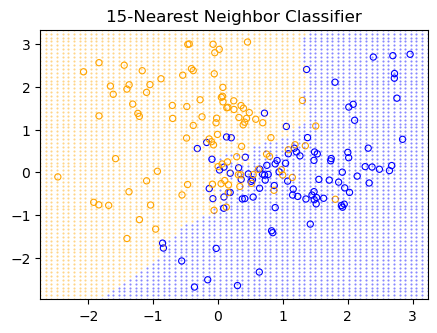

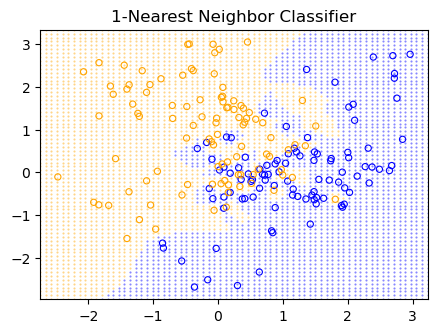

In [13]:
ax1 = plot_knn(x_blue, x_orange, 15)
ax1.set_title("15-Nearest Neighbor Classifier")

ax2 = plot_knn(x_blue, x_orange, 1)
ax2.set_title("1-Nearest Neighbor Classifier")

plt.show()

### 2.3.3 From Least Squares to Nearest Neighbors

#### Classification error function

In [14]:
def loss_func(y_true: np.array, y_pred: np.array) -> float:
    # Rule from formula (2.7)
    y_pred_class = np.where(y_pred > 0.5, 1, 0)
    
    # Misclassification error
    error = np.abs(y_true - y_pred_class).mean()
    
    return error

#### Data

In [15]:
# Generate data
len_data = 10_200
len_train = 200
len_test = 10_000

data = generate_data(len_data)

X = data[0]
y = data[1]

# Split: train and test
X_train = X[:len_train, :]
y_train = y[:len_train]

X_test = X[-len_test:, :]
y_test = y[-len_test:]

#### Parameters to evaluate

In [16]:
NB_NEIGHBORS_RANGE = [1, 3, 5, 7, 9, 11, 14, 17, 21, 26, 31,
                      38, 45, 57, 69, 85, 101, 126, 151]

#### Plot function 

In [17]:
from matplotlib.ticker import MaxNLocator

In [18]:
def plot_misclass(knn_train_error: np.array, knn_test_error: np.array,
                  linear_train_error: np.array, linear_test_error: np.array):
    
    linear_degree_freedom = 200/3

    fig, ax = plt.subplots(1, figsize=(5.5, 4))

    ax.plot(NB_NEIGHBORS_RANGE, knn_train_error, linestyle='-', marker=".",
            color='mediumturquoise', label="Train")

    ax.plot(NB_NEIGHBORS_RANGE, knn_test_error, linestyle='-', marker=".",
            color='orange', alpha=0.7, label="Test")
   
    ax.scatter([linear_degree_freedom], linear_train_error, marker="s",
               color='mediumturquoise')
               
    ax.scatter([linear_degree_freedom], linear_test_error, marker="s",
               color='orange', alpha=0.7)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("k - Number of Nearest Neighbors")
    ax.set_ylabel("Test Error")
    ax.invert_xaxis()
    
    plt.legend()
    plt.show()

#### Without sklearn

##### Prediction and error functions

In [19]:
# Linear model calssification error
def linear_error(X_train: np.ndarray, y_train: np.ndarray,
                 X_test: np.ndarray, y_test: np.ndarray) -> np.ndarray:
    
    size_train = len(y_train)
    size_test = len(y_test)
    
    # Fit the parameters
    coef_train = linear_model_fit(X_train, y_train)

    # Add column of one as the first column of X
    X_train = np.column_stack((np.ones(size_train), X_train))
    X_test = np.column_stack((np.ones(size_test), X_test))
    
    # Compute training and test error
    train_error = loss_func(y_train, X_train @ coef_train) 
    test_error = loss_func(y_test, X_test @ coef_train) 
    
    return (train_error, test_error)

In [20]:
# knn: prediction of several points
def knn_predict_multi(nb_neighbors: int, point: np.array,
                      x_train: np.array, y_train: np.array) -> float:
    
    res = []
    for p in point:
        res.append(knn_predict(nb_neighbors, p, x_train, y_train))
    
    return np.array(res)

# knn model classification error
def knn_error(nb_neighbors: int, X_train: np.ndarray, y_train: np.ndarray,
              X_test: np.ndarray, y_test: np.ndarray) -> np.ndarray:
    
    sample_size_train = len(y_train)
    sample_size_test = len(y_test)
    
    # Train error
    y_train_predict = knn_predict_multi(nb_neighbors,
                                        X_train,
                                        X_train,
                                        y_train)
    
    train_error = loss_func(y_train, y_train_predict) 
    
    # Test error
    y_test_predict = knn_predict_multi(nb_neighbors,
                                       X_test,
                                       X_train,
                                       y_train) 

    test_error = loss_func(y_test, y_test_predict) 
       
    return (train_error, test_error)

##### Errors

In [21]:
# Linear model errors
linear_train_error, linear_test_error = linear_error(X_train, y_train,
                                                     X_test, y_test)

In [22]:
# knn model erros with different "k" parameters
misclas_knn = np.array([knn_error(param, X_train, y_train, X_test, y_test)
                        for param in NB_NEIGHBORS_RANGE])

knn_train_error, knn_test_error = misclas_knn[:,0], misclas_knn[:,1]

##### Plot results

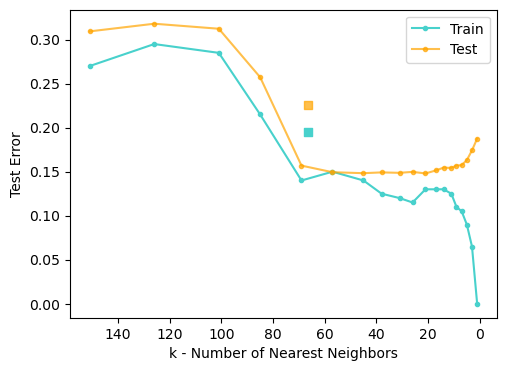

In [23]:
plot_misclass(knn_train_error, knn_test_error, linear_train_error,
              linear_test_error)         

#### With sklearn

##### Define the models

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

In [25]:
reg_linear = LinearRegression(fit_intercept=True).fit(X_train, y_train)
cls_knn = KNeighborsClassifier(algorithm="brute")

##### Errors

In [26]:
import warnings
from sklearn.model_selection import validation_curve, PredefinedSplit
from sklearn.metrics import make_scorer

# Disable warning
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

In [27]:
# Linear model
y_train_pred = reg_linear.predict(X_train)
y_test_pred = reg_linear.predict(X_test)
linear_train_error = loss_func(y_train, y_train_pred)
linear_test_error = loss_func(y_test, y_test_pred)

In [28]:
# Predifined split
test_fold = [-1]*len_train + [1]*len_test
ps = PredefinedSplit(test_fold)

# Personnalize scorer
custom_score = make_scorer(loss_func)

# knn model erros with different "k" parameters
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    knn_train_error, knn_test_error = validation_curve(cls_knn, X, y,
                                                       param_name='n_neighbors',
                                                       param_range=NB_NEIGHBORS_RANGE,
                                                       cv=ps,
                                                       scoring=custom_score)

##### Plot results

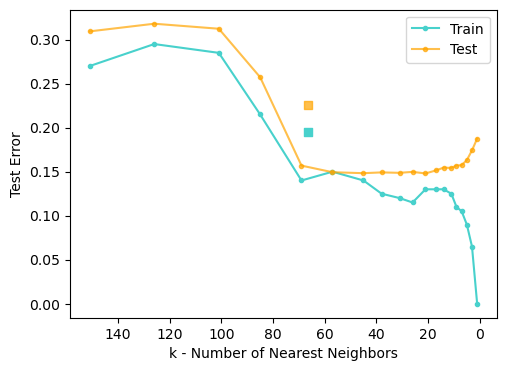

In [29]:
plot_misclass(knn_train_error, knn_test_error, linear_train_error,
              linear_test_error)